## Start by importing the linear model and check the RMSLE:

In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
lm = LinearRegression()

import statsmodels.api as sm
import warnings
from sklearn.exceptions import DataConversionWarning

#Load our two Data Frames
AmesDummiesOrdinalCols = pd.read_csv('AmesOrdinalManualAICFinal.csv', index_col=0)
AmesDummiesOrdinal = pd.read_csv('AmesOrdinalManualFeatures.csv', index_col=0)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [4]:
AmesDummiesOrdinalCols.shape

(1166, 62)

In [5]:
AmesDummiesOrdinalF = AmesDummiesOrdinal[list(AmesDummiesOrdinalCols.columns)]

In [6]:
OriginalList = list(AmesDummiesOrdinalF.columns).remove('SalePrice')

In [7]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
AmesDF = AmesDummiesOrdinalF.copy()

In [8]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

AmesDF2 = AmesDF.copy()
AmesDF = AmesDF.iloc[trainIdxes,]
AmesDFTest = AmesDF2.iloc[testIdxes,]

In [9]:
#Reindex the AmesDF:
AmesDF.index = range(1166)

In [10]:
#Run Linear Regression on the Overall (80%) train set, based on earlier K-fold:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Run the linear regression and check RMSLE:
lm.fit(X, Y)
lmscore = lm.score(X, Y)
lmpredict = lm.predict(X)

#Get scores for the Test set
lmtestscore = lm.score(testX, testY)
lmpredict = lm.predict(testX)

RMSLE = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(lmpredict), 2)))

print("The train R^2 score is: " + str(lmscore))
print("The test R^2 score is: " + str(lmtestscore))
print("The test RMSLE is: " + str(RMSLE))


The train R^2 score is: 0.9168239937634461
The test R^2 score is: 0.8780406865239909
The test RMSLE is: 0.16152859677884812


## Ridge regression:

In [11]:
#Ridge regression

from sklearn.linear_model import Ridge 
from sklearn import preprocessing

ridge_df=AmesDummiesOrdinalF.copy()

SalePrice_r=ridge_df.SalePrice
ridge_df=ridge_df.drop('SalePrice',axis=1)

#Standardize all input columns to 0-1
def standize_df(df,collist):
    for col in collist:
        stan_df=df[[col]]
        min_max_scaler = preprocessing.MinMaxScaler()
        standardized=min_max_scaler.fit_transform(stan_df)
        stan2_df=pd.DataFrame(standardized,columns=stan_df.columns,index=stan_df.index)
        df[[col]]=stan2_df
    return df


collist=list(ridge_df.columns)
ridge_df=standize_df(ridge_df,collist)

#Split to 80%-20% with seed 19
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size= 292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))
rX = ridge_df.iloc[trainIdxes]
rtestX  = ridge_df.iloc[testIdxes]
rY = SalePrice_r.iloc[trainIdxes]
rtestY  = SalePrice_r.iloc[testIdxes]

# with 10 k-fold test, the best lambda=5.129
ridge=Ridge()
ridge.set_params(alpha=5.129)
ridge.fit(rX,rY)
rtrain_score=ridge.score(rX,rY)
rtest_score= ridge.score(rtestX,rtestY)

ridgepredict = ridge.predict(rtestX)
RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(rtestY)-np.log1p(ridgepredict), 2)))


print ('train_score(R2)\t',rtrain_score)
print ('test_score(R2) \t',rtest_score)
print ('Ridge RMSLE \t',RMSLEvalue)

train_score(R2)	 0.8978218675617995
test_score(R2) 	 0.8903082126135534
Ridge RMSLE 	 0.1431872146301889


## Now, import the Random Forest model and check the overall RMSLE:

In [13]:
#Run Random Forest on the Overall (80%) train set, based on earlier K-fold:

#Import RandomForestRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()
randomForest.set_params(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, 
                        n_estimators=200)

#Run the linear regression and check RMSLE:
randomForest.fit(X, Y)
rfscore = randomForest.score(X, Y)
rfpredict = randomForest.predict(X)

#Get scores for the Test set
rftestscore = randomForest.score(testX, testY)
testpredictrf = randomForest.predict(testX)

RMSLErf = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictrf), 2)))

print("The train R^2 score is: " + str(rfscore))
print("The test R^2 score is: " + str(rftestscore))
print("The test RMSLE is: " + str(RMSLErf))

The train R^2 score is: 0.9999963781084349
The test R^2 score is: 0.9046837532832553
The test RMSLE is: 0.1313529049474037


## Now, import the Gradient Boost model and check the overall RMSLE:

In [37]:
#Run Gradient Boost on the Overall (80%) train set, based on earlier K-fold:

#Import GradientBoostRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
gradientBoost = ensemble.GradientBoostingRegressor()
gradientBoost.set_params(n_estimators=800, min_samples_split=6, min_samples_leaf=4, max_features='log2', max_depth=2, loss='huber')

#Run the linear regression and check RMSLE:
gradientBoost.fit(X, Y)
gbscore = gradientBoost.score(X, Y)
gbpredict = gradientBoost.predict(X)

#Get scores for the Test set
gbtestscore = gradientBoost.score(testX, testY)
testpredictgb = gradientBoost.predict(testX)

RMSLEgb = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictgb), 2)))

print("The train R^2 score is: " + str(gbscore))
print("The test R^2 score is: " + str(gbtestscore))
print("The test RMSLE is: " + str(RMSLEgb))

The train R^2 score is: 0.9701249311217042
The test R^2 score is: 0.9194008101010613
The test RMSLE is: 0.12225182827457319


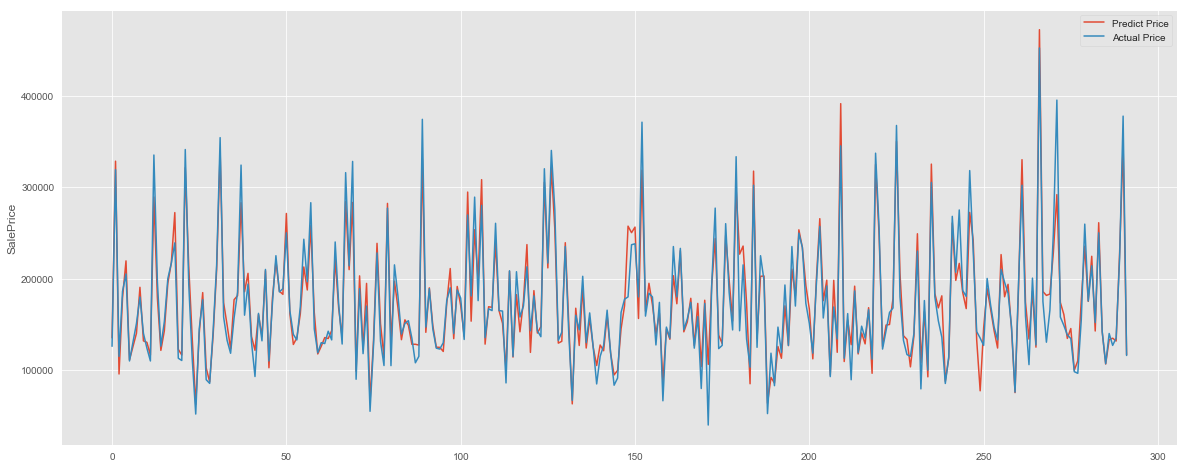

<Figure size 432x288 with 0 Axes>

In [54]:
plt.style.use('ggplot')
x = plt.figure(figsize=(20,8))
plt.plot(range(292),testpredictgb,label="Predict Price")
plt.plot(range(292),testY,label="Actual Price")
plt.legend(loc="best")
plt.ylabel("SalePrice")
plt.show()
plt.savefig('gb.png')

In [38]:
#Run XGBoost on the Overall (80%) train set, based on earlier K-fold:

#Import GradientBoostRegressor and set parameters to those found in the hyperparameter testing:
from xgboost import XGBRegressor
xgBoost = XGBRegressor()
xgBoost.set_params(n_estimators=800, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', max_depth = 2,
                loss = 'huber', gamma=0.2, colsample_bytree=0.6)

#Run the linear regression and check RMSLE:
xgBoost.fit(X, Y)
xgbscore = xgBoost.score(X, Y)
xgbpredict = xgBoost.predict(X)

#Get scores for the Test set
xgbtestscore = xgBoost.score(testX, testY)
testpredictxgb = xgBoost.predict(testX)

RMSLExgb = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictxgb), 2)))

print("The train R^2 score is: " + str(xgbscore))
print("The test R^2 score is: " + str(xgbtestscore))
print("The test RMSLE is: " + str(RMSLExgb))

The train R^2 score is: 0.983175156175541
The test R^2 score is: 0.9167902673936776
The test RMSLE is: 0.12122443145618578


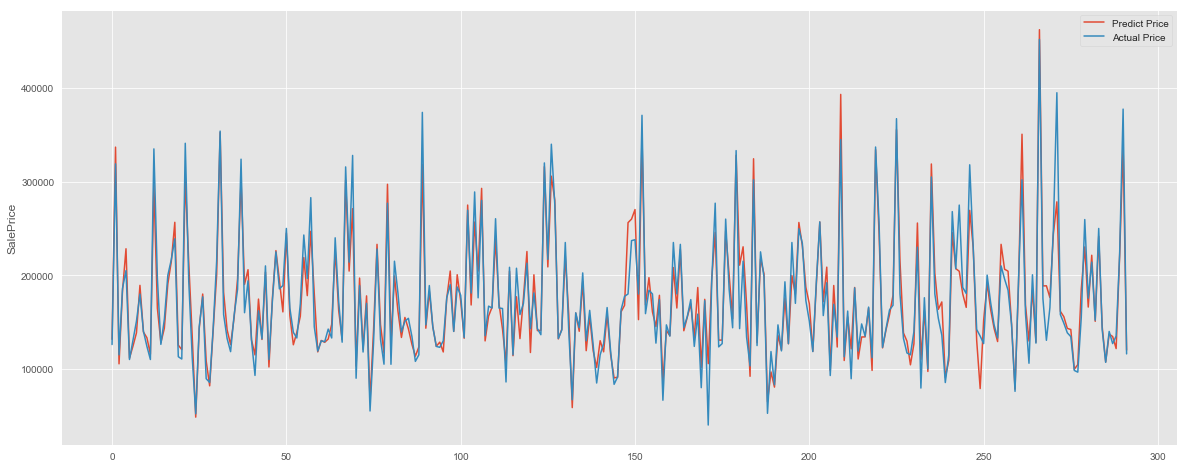

<Figure size 432x288 with 0 Axes>

In [53]:
plt.style.use('ggplot')
x = plt.figure(figsize=(20,8))
plt.plot(range(292),testpredictxgb,label="Predict Price")
plt.plot(range(292),testY,label="Actual Price")
plt.legend(loc="best")
plt.ylabel("SalePrice")
plt.show()
plt.savefig('xgb.png')

## Combine (stack) these results to generate a prediction for SalePrice and see if it outperforms the gradient boosting prediction

In [22]:
stackedpredict = (testpredictgb + testpredictxgb + testpredictrf + lmpredict + ridgepredict)/5
RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))
print("The balanced stacked-model RMSLE is: " + str(RMSLEstacked))

The balanced stacked-model RMSLE is: 0.11980502940512709


In [23]:
XGBoostPct = []
GradientPct = []
LinearPct = []
BoostPct = []
RidgePct = []
RMSLE = []
for i in list(range(25)):

    for j in list(range(25)):

        for k in list(range(25)):
            
            for l in list(range(25)):
                
                for m in list(range(25)):
            
                    if (i + j + k + l + m) != 25:
                        continue
                    GradientPct.append(i)
                    LinearPct.append(k)
                    BoostPct.append(j)
                    RidgePct.append(l)
                    XGBoostPct.append(m)


                    stackedpredict = (i*testpredictgb + j*testpredictrf + k*lmpredict + l*ridgepredict + m*testpredictxgb)/25
                    RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))
                    RMSLE.append(RMSLEstacked)
                    #print("gradient %: " + str(i) + ", randomforest%: " + str(j) + ", linear%: " + str(k) + ", XGboost%: " + str(m) + ", RMSLE= " + str(RMSLEstacked))
    

In [24]:
Gradient = 5*pd.Series(GradientPct)
Linear = 5*pd.Series(LinearPct)
RandomForest = 5*pd.Series(BoostPct)
Ridge = 5*pd.Series(RidgePct)
XGBoost = 5*pd.Series(XGBoostPct)

RMSLESeries = pd.Series(RMSLE)

StackGridSearchDF = pd.DataFrame({'LinearPct':Linear, 'RidgePct':Ridge, 'RForestPct':RandomForest, 
                                  'GBoostPct':Gradient, 'XGBoostPct': XGBoost,'RMSLE':RMSLESeries})

In [25]:
StackGridSearchDF.sort_values(by='RMSLE', axis=0, ascending=False).head()

,LinearPct,RidgePct,RForestPct,GBoostPct,XGBoostPct,RMSLE
347,120,5,0,0,0,0.159417
346,120,0,0,0,5,0.158076
3596,120,0,0,5,0,0.157695
345,115,10,0,0,0,0.157443
672,120,0,5,0,0,0.156347


In [26]:
StackGridSearchDF.sort_values(by='RMSLE', axis=0).head()

,LinearPct,RidgePct,RForestPct,GBoostPct,XGBoostPct,RMSLE
12495,20,0,35,20,50,0.116847
12611,20,0,40,20,45,0.116850
14382,20,0,35,25,45,0.116853
10471,20,0,40,15,50,0.116854
10482,25,0,40,15,45,0.116874


In [27]:
#Propose 36% Gradient Boost, 24% XGboost, 20% Random Forrest, 20% Linear
stackedpredict = (2.0*gradientBoost.predict(testX) + 5.0*xgBoost.predict(testX)+ 3.5*randomForest.predict(testX) 
                  + 2.0*lm.predict(testX))/12.5

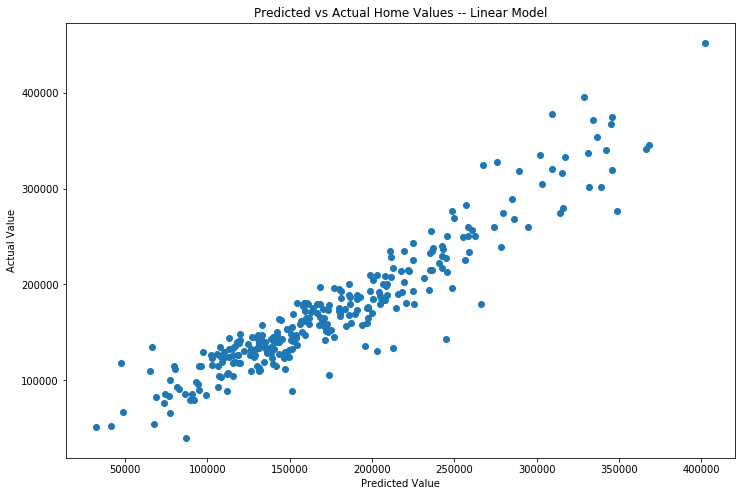

<Figure size 432x288 with 0 Axes>

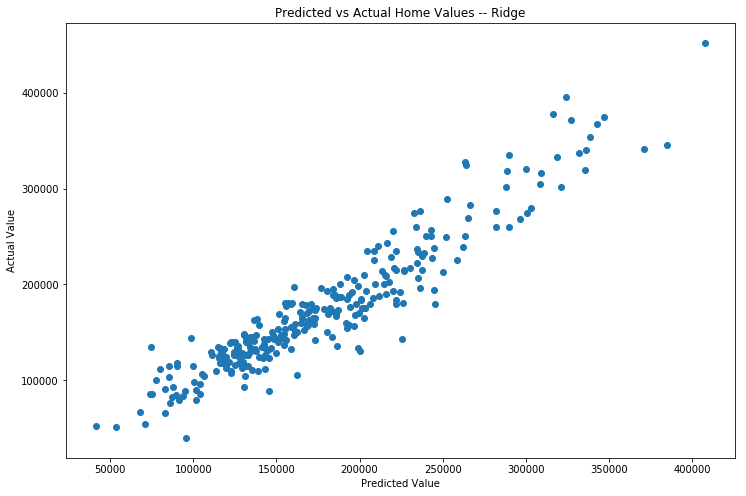

<Figure size 432x288 with 0 Axes>

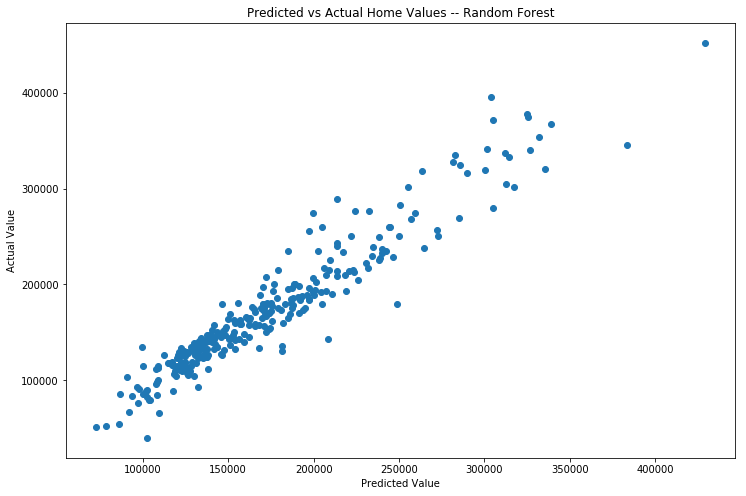

<Figure size 432x288 with 0 Axes>

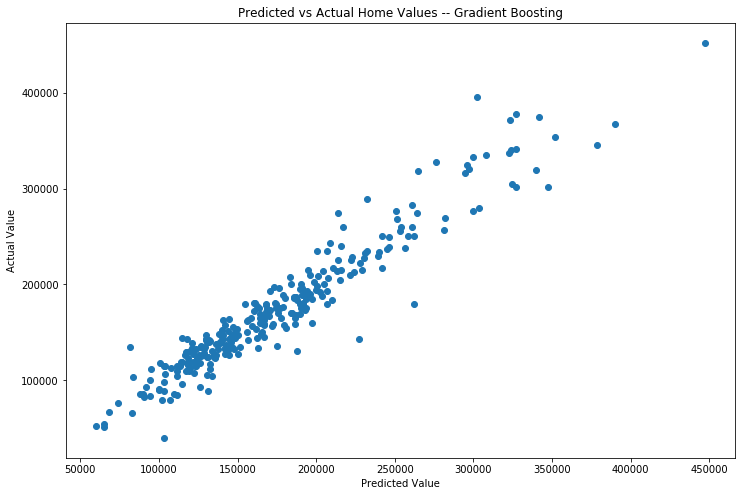

<Figure size 432x288 with 0 Axes>

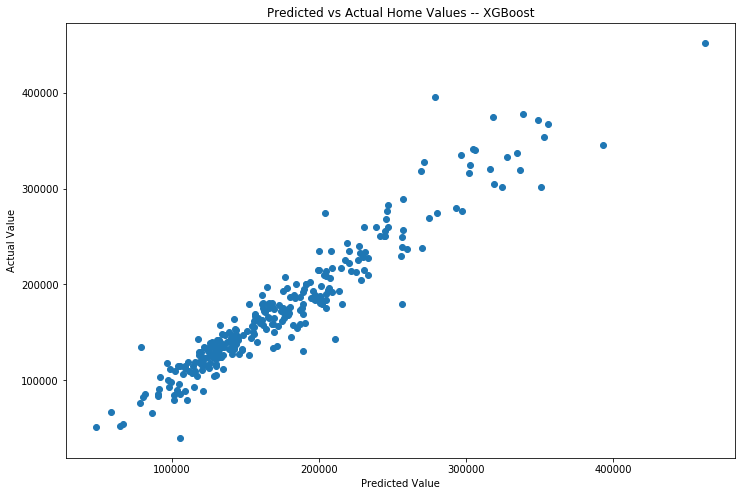

<Figure size 432x288 with 0 Axes>

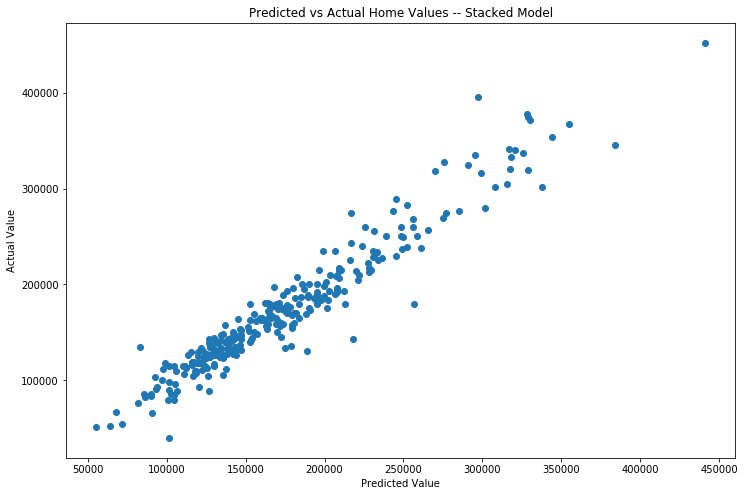

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt

for tup in [('Linear Model', lmpredict), ('Ridge', ridgepredict), ('Random Forest', testpredictrf), ('Gradient Boosting', testpredictgb), ('XGBoost', testpredictxgb), ('Stacked Model', stackedpredict)]:

    plt.figure(figsize=(12,8))
    plt.scatter(tup[1], testY)
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('Predicted vs Actual Home Values -- ' + tup[0])   
    plt.show()
    plt.savefig('PredvActual.png')

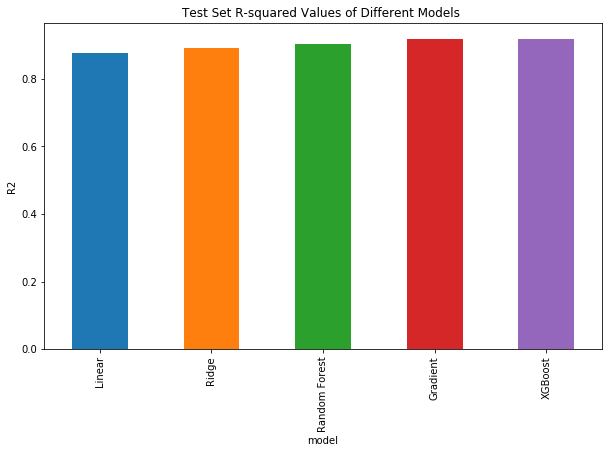

In [44]:
cv_compare = pd.DataFrame({'model': ['Linear', 'Ridge', 'Random Forest', 'Gradient', 'XGBoost'],
                          'R2': [lmtestscore, rtest_score, rftestscore, gbtestscore, xgbtestscore]})
cv_compare.plot.bar(x='model', y='R2', figsize=(10,6), legend=False)
plt.title('Test Set R-squared Values of Different Models ')
plt.xlabel('model')
plt.ylabel('R2')
plt.savefig('R2model.png')